**1.** Run the following cells to setup the environment

In [37]:
import requests, pandas as pd, json, copy
from IPython.display import JSON, Image, HTML
from requests.auth import HTTPBasicAuth

In [38]:
URL = 'http://mira.isi.edu:8000'
auth = HTTPBasicAuth('mint', 'm290sjafds8!')

**2.** Load a dataset that we want to model, and show the content of the dataset.

The dataset is supposed to be a [relational table](https://www.ibm.com/support/knowledgecenter/SSWU4L/Data/imc_Data/Data_q_a_watson_assistant/Relational_Tables371.html). If the data format is CSV, the first row is the header.

In [39]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('~/Downloads/s02.csv', header=0)
df.head(5)

,Unnamed: 0,date,cmname,unit,category,price,currency,country,admname,adm1id,mktname,mktid,cmid,ptid,umid,catid,sn,default
0,NaN,#date,#item+name,#item+unit,#item+type,#value,#currency,#country+name,#adm1+name,#adm1+code,#name+market,NaN,#item+code,NaN,NaN,#item+type+code,#meta+id,NaN
1,NaN,7/15/2005,Sorghum - Wholesale,100 KG,cereals and tubers,238,ETB,Ethiopia,Addis Ababa,1227,Addis Ababa,480.0,65,14.0,9.0,1,480_65_14_9,NaN
2,NaN,8/15/2005,Sorghum - Wholesale,100 KG,cereals and tubers,250,ETB,Ethiopia,Addis Ababa,1227,Addis Ababa,480.0,65,14.0,9.0,1,480_65_14_9,NaN
3,NaN,9/15/2005,Sorghum - Wholesale,100 KG,cereals and tubers,248,ETB,Ethiopia,Addis Ababa,1227,Addis Ababa,480.0,65,14.0,9.0,1,480_65_14_9,NaN
4,NaN,10/15/2005,Sorghum - Wholesale,100 KG,cereals and tubers,233,ETB,Ethiopia,Addis Ababa,1227,Addis Ababa,480.0,65,14.0,9.0,1,480_65_14_9,NaN


**3.** To send the table to the API for annotation, we need to convert the original table into a JSON format below:
```json
{
    "ontologies": ["http://wikiba.se/ontology#"],
    "source": [
        {"name": "<column name>", "values": ["<value of the column in first row>", "<value of the column in second row>", "..."]
    ]
}
```
and send it in the body of a `POST` request to `/v1.1/annotate`

In [42]:
payload = {
    "ontologies": ["http://datamart.isi.edu/ontology#"],
    "source": [
        {"name": "" if c.startswith("Unnamed:") else c, "values": df[c].tolist()}
        for c in df.columns
    ]
}
resp = requests.post(URL + "/v1.1/annotate", json=payload, auth=auth)
assert resp.status_code == 200

**4.** The JSON response that the server returns are in the following format:
```json
{
    "sms": [{
        "<ont_class_id>": {
            "iri": "<uri of the ontology class>",
            "properties": [
                ["<ontology predicate 1>", "<column_index>"], 
                ["<ontology predicate 2>", "<column_index>"]
            ],
            "links": [
                ["<ontology predicate 1>", "<ont_class_id>"]
            ]
        }
    }],
    "semantic_types": [
        [{
            "class": "<ontology class uri>",
            "predicate": "<ontology predicate uri>",
            "prob": "<probability of this semantic type (float)>"
        }]
    ],
    "prefixes": {
        "<prefix>": "<url>"
    }
}
```
where:
* `sms` is a list of predicted semantic models, sorted by the likelihood
* `semantic_types` is a list containing predicted semantic types for each column. In particular, an ith item in the list is predicted semantic types of the ith column in the data source.

In [43]:
JSON(resp.json(), indent=4)

<IPython.core.display.JSON object>

Run the following cell to tag each column with a type

In [44]:
headers = df.columns.tolist()

In [45]:
data = resp.json()
columns = []
for ci, c in enumerate(headers):
    stype = data['semantic_types'][ci]
    cname = f"{stype[0]['predicate']}"
    columns.append(cname)

df.loc[0] = columns

In [46]:
df.head(10)

,Unnamed: 0,date,cmname,unit,category,price,currency,country,admname,adm1id,mktname,mktid,cmid,ptid,umid,catid,sn,default
0,dm:main_subject,dm:time,dm:main_subject,dm:unit,p:P4224,dm:variable,dm:unit,dm:location/country,dm:qualifier,dm:location/admin1,dm:qualifier,dm:variable,dm:qualifier,dm:main_subject,dm:location/latitude,dm:variable,dm:main_subject,dm:main_subject
1,NaN,7/15/2005,Sorghum - Wholesale,100 KG,cereals and tubers,238,ETB,Ethiopia,Addis Ababa,1227,Addis Ababa,480,65,14,9,1,480_65_14_9,NaN
2,NaN,8/15/2005,Sorghum - Wholesale,100 KG,cereals and tubers,250,ETB,Ethiopia,Addis Ababa,1227,Addis Ababa,480,65,14,9,1,480_65_14_9,NaN
3,NaN,9/15/2005,Sorghum - Wholesale,100 KG,cereals and tubers,248,ETB,Ethiopia,Addis Ababa,1227,Addis Ababa,480,65,14,9,1,480_65_14_9,NaN
4,NaN,10/15/2005,Sorghum - Wholesale,100 KG,cereals and tubers,233,ETB,Ethiopia,Addis Ababa,1227,Addis Ababa,480,65,14,9,1,480_65_14_9,NaN
5,NaN,11/15/2005,Sorghum - Wholesale,100 KG,cereals and tubers,252,ETB,Ethiopia,Addis Ababa,1227,Addis Ababa,480,65,14,9,1,480_65_14_9,NaN
6,NaN,12/15/2005,Sorghum - Wholesale,100 KG,cereals and tubers,253,ETB,Ethiopia,Addis Ababa,1227,Addis Ababa,480,65,14,9,1,480_65_14_9,NaN
7,NaN,1/15/2006,Sorghum - Wholesale,100 KG,cereals and tubers,243,ETB,Ethiopia,Addis Ababa,1227,Addis Ababa,480,65,14,9,1,480_65_14_9,NaN
8,NaN,2/15/2006,Sorghum - Wholesale,100 KG,cereals and tubers,237,ETB,Ethiopia,Addis Ababa,1227,Addis Ababa,480,65,14,9,1,480_65_14_9,NaN
9,NaN,3/15/2006,Sorghum - Wholesale,100 KG,cereals and tubers,245,ETB,Ethiopia,Addis Ababa,1227,Addis Ababa,480,65,14,9,1,480_65_14_9,NaN


Run the following cell to draw the most probable semantic model

In [47]:
data = resp.json()
data = {
    "prefixes": data['prefixes'],
    "sm": data['sms'][0],
    "columns": df.columns.tolist()
}

In [48]:
resp2 = requests.post(URL + "/v1/draw", json=data, auth=auth, stream=all)
assert resp2.status_code == 200

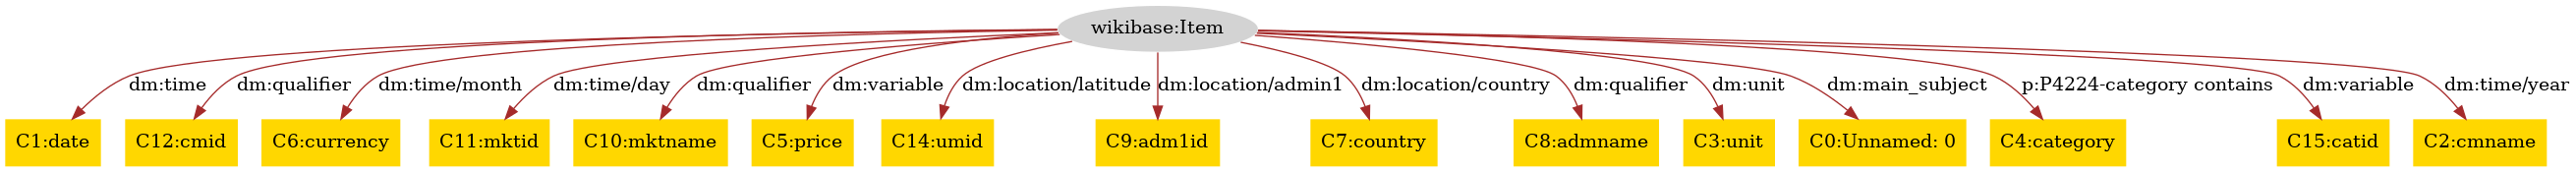

In [49]:
display(Image(resp2.content))